# Analyzing Storm Data

## Import the required packages.

In [1]:
import numpy as np
import pandas as pd
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from amazon_cred import ENDPOINT, PORT, USER, PASSWORD, DATABASE
from data_constants import BLS_CPI_CSV

# Regression Analysis

Steps
1. Get data from the database
2. Consider only rows that belong to the 3 storm categories
3. Adjust the total damage using to 2020 dollars consumer price index
4. Split data into major storm categories: Tropical Cyclones/Floods, Tornadoes, Wildfires
5. Split each category data into train, test
6. String variables should be one hot encoded
7. Apply scaling

In [2]:
conn = psycopg2.connect(
    host=ENDPOINT,
    port=PORT,
    user=USER,
    password=PASSWORD,
    database = DATABASE
)
with conn:
    select = """SELECT * from counties"""
    df_counties = pd.read_sql(select, con=conn)
conn.close()

In [3]:
analysis_df = df_counties[['TOTAL_DAMAGE', 'EVENT_DATE', 'EVENT_TYPE', 
                           'DURATION', 'DATA_COL', 'TORNADO_STRENGTH',
                           'Tropical Cyclones/Floods', 'Severe Local Storms', 'Wildfires/Droughts']]
analysis_df = analysis_df[(analysis_df['Tropical Cyclones/Floods'] == True) |
                          (analysis_df['Severe Local Storms'] == True) |
                          (analysis_df['Wildfires/Droughts'] == True)]
# Split the DATA_COL into individual columns
data_cols = [
    'population', 'num_estab', 'annual_payroll', 'num_emp', 'num_non_emp_estb', 'non_emp_revenue',
    'rank_1_ind', 'rank_1_biz_val', 'rank_1_estab', 'rank_1_emp', 
    'rank_2_ind', 'rank_2_biz_val', 'rank_2_estab', 'rank_2_emp', 
    'rank_3_ind', 'rank_3_biz_val', 'rank_3_estab', 'rank_3_emp'
]

analysis_df.reset_index(inplace=True, drop=True)
analysis_df['DATA_COL'] = analysis_df['DATA_COL'].apply(lambda data: [i for i in data.split('|') if i != ' '])

data_df = pd.DataFrame(analysis_df['DATA_COL'].to_list(), columns=data_cols)
analysis_df = pd.concat([analysis_df, data_df], axis=1)

# Convert columns to numeric data
num_cols = ['population', 'num_estab', 'annual_payroll', 'num_emp', 'num_non_emp_estb', 'non_emp_revenue',
            'rank_1_biz_val', 'rank_1_estab', 'rank_1_emp',
            'rank_2_biz_val', 'rank_2_estab', 'rank_2_emp',
            'rank_3_biz_val', 'rank_3_estab', 'rank_3_emp']
for c in num_cols:
    analysis_df[c] = analysis_df[c].apply(pd.to_numeric, errors='coerce')
    analysis_df[c] = analysis_df[c].fillna(0)

## Apply the inflation adjustment to dollar figures for each event

In [4]:
df_bls_cpi = pd.read_csv(BLS_CPI_CSV)
df_cpi_2020 = df_bls_cpi[df_bls_cpi['year']==2020] # adjust damage to 2020 dollars
df_cpi_2020.reset_index(drop=True, inplace=True) # inflation for month 12 is at iloc 0;

def apply_inflation(row):
    event_year = row['EVENT_DATE'].year
    event_mth = row['EVENT_DATE'].month
    
    df_cpi_year = df_bls_cpi[df_bls_cpi['year']==event_year]
    df_cpi_year.reset_index(drop=True, inplace=True)

    frac = (df_cpi_2020.iloc[12 - event_mth]['value']/df_cpi_year[df_cpi_year['period']==event_mth].iloc[0]['value'])
    
    row['TOTAL_DAMAGE'] = row['TOTAL_DAMAGE'] * frac
    row['annual_payroll'] = row['annual_payroll'] * frac
    row['non_emp_revenue'] = row['non_emp_revenue'] * frac
    row['rank_1_biz_val'] = row['rank_1_biz_val'] * frac
    row['rank_2_biz_val'] = row['rank_2_biz_val'] * frac
    row['rank_3_biz_val'] = row['rank_3_biz_val'] * frac
    return row

analysis_df = analysis_df.apply(apply_inflation, axis=1)
analysis_df.drop(columns=['DATA_COL', 'EVENT_DATE'], inplace = True)
analysis_df['DURATION'] = analysis_df['DURATION']/(60*1e9) # convert the duration in minutes (from nanosec)

## Split data into major storm categories: Tropical Cyclones/Floods, Tornadoes, Wildfires

In [5]:
cat1_df = analysis_df[analysis_df['Tropical Cyclones/Floods'] == True]
cat2_df = analysis_df[analysis_df['EVENT_TYPE'] == 'Tornado']
cat3_df = analysis_df[analysis_df['Wildfires/Droughts'] == True]

cat1_df = cat1_df.drop(columns = ['TORNADO_STRENGTH', 
                        'Tropical Cyclones/Floods', 'Severe Local Storms','Wildfires/Droughts'])
cat2_df = cat2_df.drop(columns = ['EVENT_TYPE', 
                        'Tropical Cyclones/Floods', 'Severe Local Storms','Wildfires/Droughts'])
cat3_df = cat3_df.drop(columns = ['TORNADO_STRENGTH', 
                        'Tropical Cyclones/Floods', 'Severe Local Storms','Wildfires/Droughts'])

def split_tornado_strength(row):
    cols = row['TORNADO_STRENGTH'].split(',')
    row['Tornado_f_scale'] = int(cols[0][-1])
    row['Tornado_len'] = float(cols[1])
    row['Tornado_width'] = float(cols[2])
    return row
cat2_df = cat2_df.apply(split_tornado_strength, axis=1)
cat2_df.drop(columns = ['TORNADO_STRENGTH'], inplace=True)

### Correlation matrix

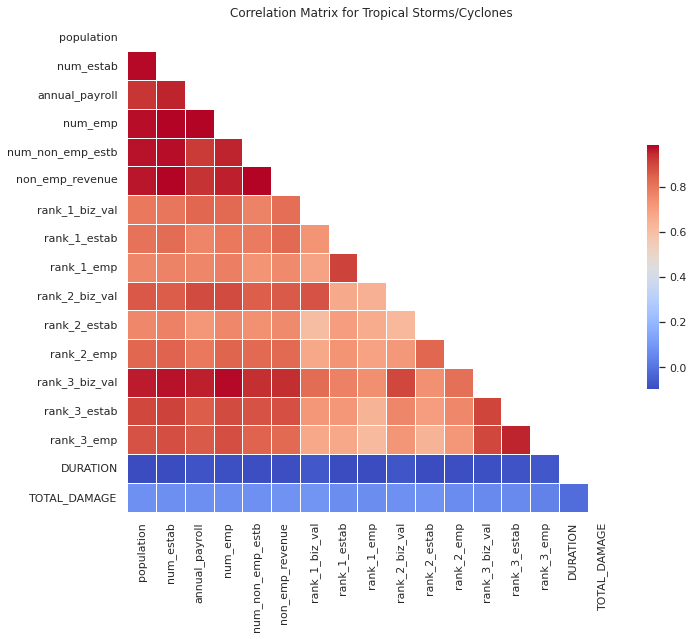

In [7]:
sns.set_theme(style="white")

lst_cols = ['population', 'num_estab', 'annual_payroll', 'num_emp', 'num_non_emp_estb', 'non_emp_revenue',
            'rank_1_biz_val', 'rank_1_estab', 'rank_1_emp',
            'rank_2_biz_val', 'rank_2_estab', 'rank_2_emp',
            'rank_3_biz_val', 'rank_3_estab', 'rank_3_emp', 'DURATION', 'TOTAL_DAMAGE'
           ]

df = cat1_df[lst_cols]
# Compute the correlation matrix
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

ax.set_title('Correlation Matrix for Tropical Storms/Cyclones')
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});


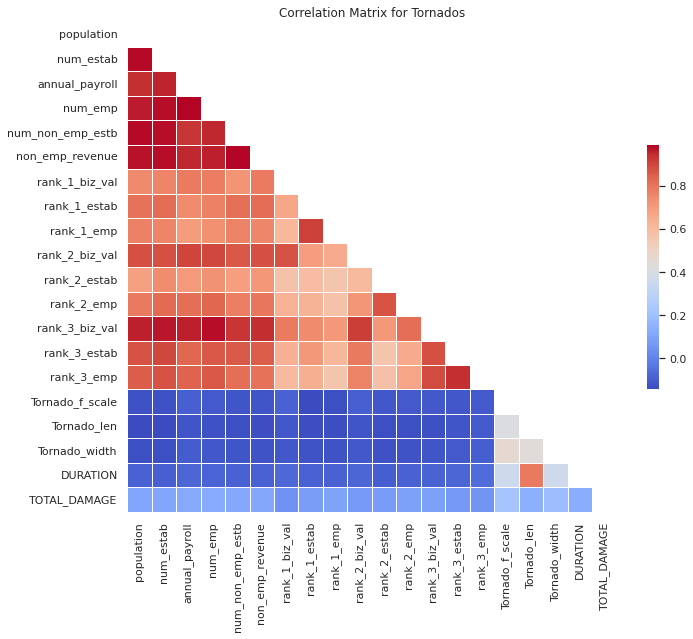

In [8]:
lst_cols = ['population', 'num_estab', 'annual_payroll', 'num_emp', 'num_non_emp_estb', 'non_emp_revenue',
            'rank_1_biz_val', 'rank_1_estab', 'rank_1_emp',
            'rank_2_biz_val', 'rank_2_estab', 'rank_2_emp',
            'rank_3_biz_val', 'rank_3_estab', 'rank_3_emp', 
            'Tornado_f_scale', 'Tornado_len', 'Tornado_width', 'DURATION', 'TOTAL_DAMAGE'
           ]
df = cat2_df[lst_cols]
# Compute the correlation matrix
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

ax.set_title('Correlation Matrix for Tornados')
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

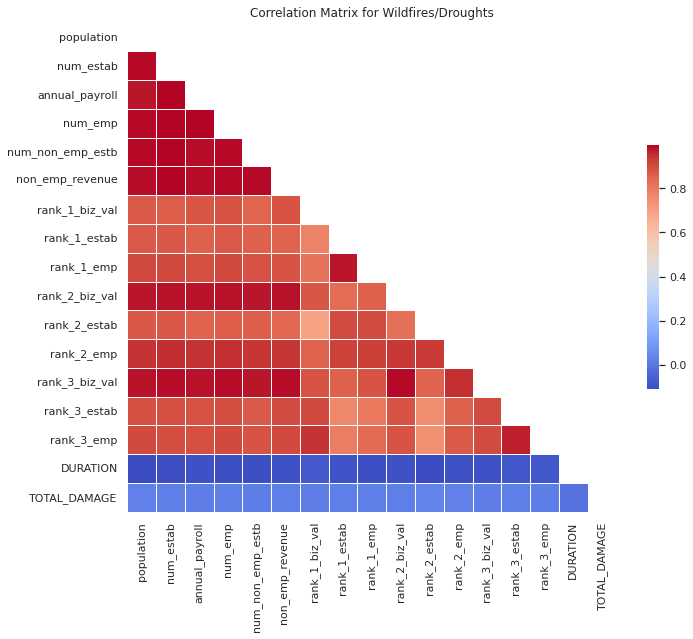

In [9]:
lst_cols = ['population', 'num_estab', 'annual_payroll', 'num_emp', 'num_non_emp_estb', 'non_emp_revenue',
            'rank_1_biz_val', 'rank_1_estab', 'rank_1_emp',
            'rank_2_biz_val', 'rank_2_estab', 'rank_2_emp',
            'rank_3_biz_val', 'rank_3_estab', 'rank_3_emp', 'DURATION', 'TOTAL_DAMAGE'
           ]

df = cat3_df[lst_cols]
# Compute the correlation matrix
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

ax.set_title('Correlation Matrix for Wildfires/Droughts')
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

### Regression Analysis using Ordinary Least Squares (Tropical Storms/Cyclones)

In [17]:
import statsmodels.formula.api as smf

formula = 'TOTAL_DAMAGE ~ population + DURATION + rank_1_biz_val + rank_2_biz_val + rank_3_biz_val'
reg = smf.ols(formula = formula, data = cat1_df).fit(maxiter=10000)
head = reg.summary().tables[0]
body = reg.summary().tables[1]
print(head)
print(body) 

                            OLS Regression Results                            
Dep. Variable:           TOTAL_DAMAGE   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     14.20
Date:                Fri, 17 Sep 2021   Prob (F-statistic):           8.06e-14
Time:                        23:37:30   Log-Likelihood:            -1.0904e+05
No. Observations:                5052   AIC:                         2.181e+05
Df Residuals:                    5046   BIC:                         2.181e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       4.791e+07   9.84e+06      4.

### Regression Analysis using Ordinary Least Squares (Tornadoes)

In [18]:
formula = 'TOTAL_DAMAGE ~ population + DURATION + Tornado_f_scale + Tornado_width + rank_1_biz_val + rank_2_biz_val + rank_3_biz_val'
reg = smf.ols(formula = formula, data = cat2_df).fit(maxiter=10000)
head = reg.summary().tables[0]
body = reg.summary().tables[1]
print(head)
print(body) 

                            OLS Regression Results                            
Dep. Variable:           TOTAL_DAMAGE   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     21.78
Date:                Fri, 17 Sep 2021   Prob (F-statistic):           2.88e-28
Time:                        23:39:53   Log-Likelihood:                -32620.
No. Observations:                1627   AIC:                         6.526e+04
Df Residuals:                    1619   BIC:                         6.530e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -5.947e+07   7.99e+06     

### Regression Analysis using Ordinary Least Squares (Wildfires/Droughts)

In [19]:
formula = 'TOTAL_DAMAGE ~ population + DURATION + rank_1_biz_val + rank_2_biz_val'
reg = smf.ols(formula = formula, data = cat1_df).fit(maxiter=10000)
head = reg.summary().tables[0]
body = reg.summary().tables[1]
print(head)
print(body) 

                            OLS Regression Results                            
Dep. Variable:           TOTAL_DAMAGE   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     10.93
Date:                Fri, 17 Sep 2021   Prob (F-statistic):           7.94e-09
Time:                        23:43:35   Log-Likelihood:            -1.0906e+05
No. Observations:                5052   AIC:                         2.181e+05
Df Residuals:                    5047   BIC:                         2.182e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        5.51e+07   9.77e+06      5.

### Linear regression for Tropical Cyclones/Floods, Tornadoes, and Wildfires

### Train test split

In [10]:
df_train_cat1 = cat1_df.iloc[:, 1:]
y_cat1 = cat1_df.iloc[:, :1]

df_train_cat2 = cat2_df.iloc[:, 1:]
y_cat2 = cat2_df.iloc[:, :1]

df_train_cat3 = cat3_df.iloc[:, 1:]
y_cat3 = cat3_df.iloc[:, :1]

X_train_cat1, X_test_cat1, y_train_cat1, y_test_cat1 = train_test_split(df_train_cat1, y_cat1, random_state=42)
X_train_cat2, X_test_cat2, y_train_cat2, y_test_cat2 = train_test_split(df_train_cat2, y_cat2, random_state=42)
X_train_cat3, X_test_cat3, y_train_cat3, y_test_cat3 = train_test_split(df_train_cat3, y_cat3, random_state=42)

In [11]:
print('X_train_cat1', X_train_cat1[X_train_cat1.isna().any(axis=1)].shape)
print('X_train_cat2', X_train_cat2[X_train_cat2.isna().any(axis=1)].shape)
print('X_train_cat3', X_train_cat3[X_train_cat3.isna().any(axis=1)].shape)
print('X_test_cat1', X_test_cat1[X_test_cat1.isna().any(axis=1)].shape)
print('X_test_cat2', X_test_cat2[X_test_cat2.isna().any(axis=1)].shape)
print('X_test_cat3', X_test_cat3[X_test_cat3.isna().any(axis=1)].shape)

X_train_cat1 (0, 20)
X_train_cat2 (0, 22)
X_train_cat3 (0, 20)
X_test_cat1 (0, 20)
X_test_cat2 (0, 22)
X_test_cat3 (0, 20)


### Scaling

In [12]:
def apply_scaling(df_train, df_test):
    for col in df_train.columns:
        if col not in ['EVENT_TYPE', 'rank_1_ind', 'rank_2_ind', 'rank_3_ind']:
            scaler = StandardScaler()
            df_train[col] = scaler.fit_transform(df_train[col].values.reshape([-1,1]))
            df_test[col] = scaler.transform(df_test[col].values.reshape([-1,1]))
        else:
            continue
    return df_train, df_test

X_train_cat1, X_test_cat1 = apply_scaling(X_train_cat1.copy(), X_test_cat1.copy())
X_train_cat2, X_test_cat2 = apply_scaling(X_train_cat2.copy(), X_test_cat2.copy())
X_train_cat3, X_test_cat3 = apply_scaling(X_train_cat3.copy(), X_test_cat3.copy())
y_train_cat1, y_test_cat1 = apply_scaling(y_train_cat1.copy(), y_test_cat1.copy())
y_train_cat2, y_test_cat2 = apply_scaling(y_train_cat2.copy(), y_test_cat2.copy())
y_train_cat3, y_test_cat3 = apply_scaling(y_train_cat3.copy(), y_test_cat3.copy())

### One hot encoding of features

In [13]:
def get_one_hot_enc_df(col_name, df_train, df_test):
    ohe = OneHotEncoder(handle_unknown='ignore')
    
    output = ohe.fit_transform(df_train[col_name].values.reshape(-1, 1)).toarray()
    cols = [col_name + str(i) for i in range(output.shape[1])]
    
    df_tmp = pd.DataFrame(output, columns=cols)
    df_train.reset_index(inplace=True, drop=True)
    df_train = pd.concat([df_train, df_tmp], axis=1)

    output_test = ohe.transform(df_test[col_name].values.reshape(-1, 1)).toarray()
    df_tmp = pd.DataFrame(output_test, columns=cols)
    df_test.reset_index(inplace=True, drop=True)
    df_test = pd.concat([df_test, df_tmp], axis=1)
    
    df_train.drop(columns=[col_name], axis=1, inplace=True)
    df_test.drop(columns=[col_name], axis=1, inplace=True)
    return df_train, df_test

for c in ['rank_1_ind', 'rank_2_ind', 'rank_3_ind']:
    X_train_cat1, X_test_cat1 = get_one_hot_enc_df(c, X_train_cat1, X_test_cat1)
    X_train_cat2, X_test_cat2 = get_one_hot_enc_df(c, X_train_cat2, X_test_cat2)
    X_train_cat3, X_test_cat3 = get_one_hot_enc_df(c, X_train_cat3, X_test_cat3)

X_train_cat1, X_test_cat1 = get_one_hot_enc_df('EVENT_TYPE', X_train_cat1, X_test_cat1)
X_train_cat3, X_test_cat3 = get_one_hot_enc_df('EVENT_TYPE', X_train_cat3, X_test_cat3)

### Linear Regression

In [14]:
clf = LinearRegression()
clf.fit(X_train_cat1, y_train_cat1)
print(clf.coef_)
clf.score(X_test_cat1, y_test_cat1)

[[ 1.99165323e-02  4.51665741e-01  1.09639344e-02  1.64944459e-01
   2.07269134e-02 -1.89762652e-01  6.85072925e-02  1.04277869e-01
  -1.44812902e-01  3.80416126e-02 -7.46702317e-02  7.44296174e-02
  -6.84553337e-02 -3.47310474e-01  2.50724550e-01 -2.88132637e-01
  -1.28907812e+12 -1.28907812e+12 -1.28907812e+12 -1.28907812e+12
  -1.00360422e+12 -1.28907812e+12 -1.28907812e+12 -1.28907812e+12
  -1.28907812e+12 -1.52800481e+12 -1.52800481e+12 -1.52800481e+12
  -1.52800481e+12 -1.52800481e+12 -1.52800481e+12 -1.81347872e+12
  -1.52800481e+12 -1.52800481e+12 -1.52800481e+12 -1.52800481e+12
  -1.52800481e+12 -1.52800481e+12 -1.52800481e+12 -1.59418159e+11
  -1.59418159e+11 -1.59418159e+11 -1.59418159e+11 -1.59418159e+11
  -1.59418159e+11 -1.59418159e+11 -1.59418159e+11 -1.59418159e+11
  -1.59418159e+11 -1.59418159e+11 -1.59418159e+11 -1.59418159e+11
  -1.59418159e+11 -1.59418159e+11  7.62600874e+12  7.62600874e+12
   7.62600874e+12  7.62600874e+12  7.62600874e+12  7.62600874e+12
   7.62600

-4.4768774320549035e+21

In [15]:
cat1_df.columns

Index(['TOTAL_DAMAGE', 'EVENT_TYPE', 'DURATION', 'population', 'num_estab',
       'annual_payroll', 'num_emp', 'num_non_emp_estb', 'non_emp_revenue',
       'rank_1_ind', 'rank_1_biz_val', 'rank_1_estab', 'rank_1_emp',
       'rank_2_ind', 'rank_2_biz_val', 'rank_2_estab', 'rank_2_emp',
       'rank_3_ind', 'rank_3_biz_val', 'rank_3_estab', 'rank_3_emp'],
      dtype='object')